In [1]:
!pip install geopandas
!pip install descartes

    100% |################################| 901kB 137kB/s ta 0:00:01
    100% |################################| 1.5MB 97kB/s ta 0:00:018
    100% |################################| 11.2MB 195kB/s ta 0:00:01
    100% |################################| 17.9MB 205kB/s ta 0:00:01
    100% |################################| 40kB 222kB/s ta 0:00:01
  Running setup.py bdist_wheel for munch ... done
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch
  Found existing installation: cligj 0.4.0
    Uninstalling cligj-0.4.0:
      Successfully uninstalled cligj-0.4.0
You are using pip version 18.0, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [21]:
import geopandas as gpd
from glob import glob
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth 

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.

    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)

    return 255*(shaded + 1)/2

In [4]:
f = glob('./data/geotiff/*dem.tif')[0]
ds = rasterio.open(f)

In [5]:
f = glob('./data/shp/*/*.shp')
shps = [gpd.read_file(fs) for fs in f]

In [6]:
pnts = pd.read_csv('./data/points.csv')
pnts = gpd.GeoDataFrame(pnts, geometry=gpd.points_from_xy(pnts.Longitude, pnts.Latitude))

In [7]:
ext=[ds.bounds.left, ds.bounds.right, ds.bounds.bottom, ds.bounds.top] 

In [8]:
hs = hillshade(ds.read(1),225,45)

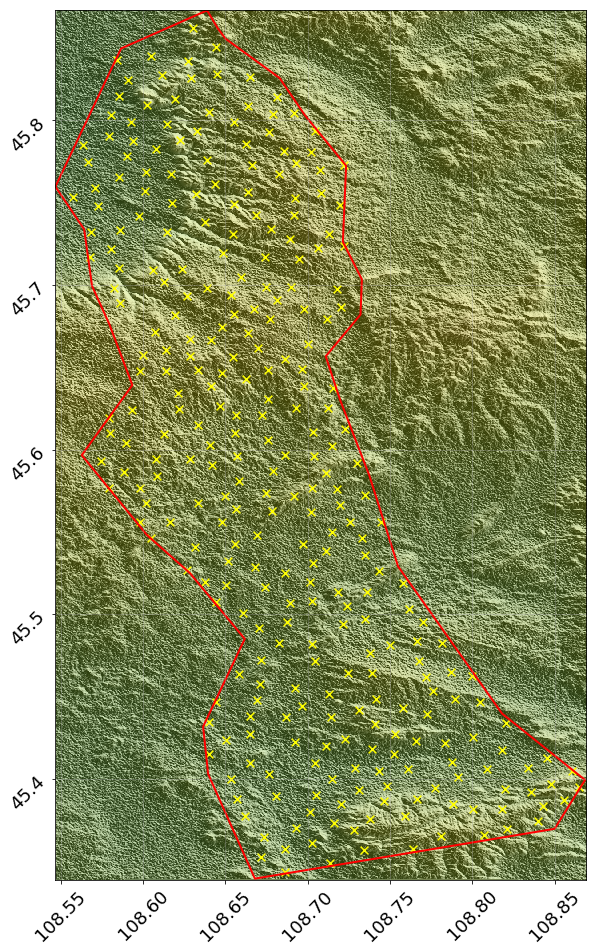

In [9]:
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(hs, extent=ext, cmap='Greys')
rasterio.plot.show(ds, ax=ax, alpha=0.3)
pnts.plot(ax=ax, marker='x', color='yellow', markersize=60)
for s in shps[:1]:
    s.plot(ax=ax, facecolor='none', edgecolor='red', lw=2)
ax.grid(alpha=0.4)
ax.tick_params(axis='both', labelsize=18, rotation=45)
fig.savefig('./out/ikhnart_sampling.png', dpi=300, bbox_inches='tight')

In [12]:
#now consider the ndvi

In [11]:
f = sorted(glob('./data/geotiff/*ndvi.tif'))
m_imgs = [rasterio.open(i) for i in f]
months = [i.split('-')[1].capitalize() for i in f]

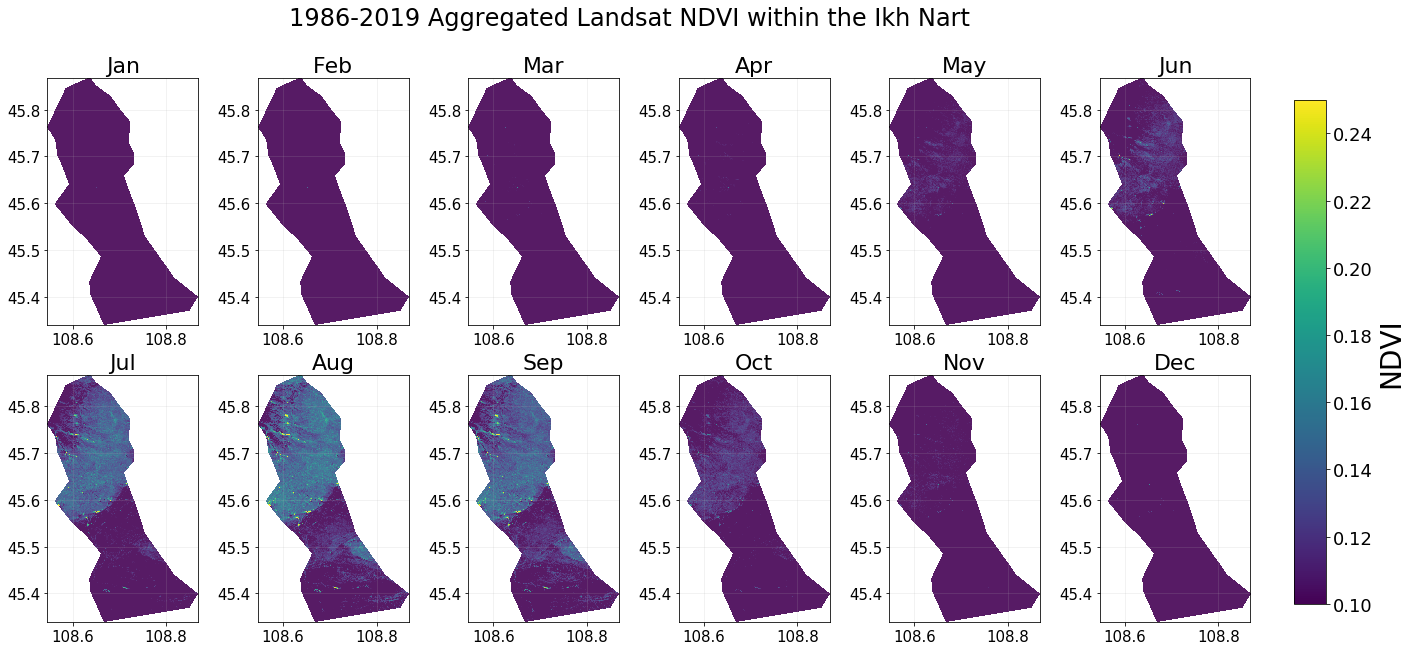

In [12]:
import matplotlib as mpl

r, c = 2,6
idxs = np.arange(r*c).reshape((r,c))
fig, ax = plt.subplots(r,c, figsize=(22,10))
mn, mx = 0.1, 0.25
for i in range(r):
    for j in range(c):
        #ax[i][j].imshow(hs, extent=ext, cmap='Greys')
        im = rasterio.plot.show(m_imgs[idxs[i][j]], ax=ax[i][j], \
                           vmin=mn, vmax=mx, alpha=0.9, extent=ext)
        ax[i][j].grid(alpha=0.2)
        ax[i][j].set_title(months[idxs[i][j]], fontsize=22)
        ax[i][j].tick_params(axis="both", labelsize=15) 
fig.suptitle('1986-2019 Aggregated Landsat NDVI within the Ikh Nart', fontsize=24)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=mn, vmax=mx)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=18) 
cb.set_label('NDVI', fontsize=28)
fig.subplots_adjust(right=0.9)

fig.savefig('./out/ikhnart_NDVI.png', dpi=300, bbox_inches='tight')


In [13]:
#now consider the climate (use pdsi)

In [14]:
f = sorted(glob('./data/geotiff/*climate.tif'))
m_imgs = [rasterio.open(i) for i in f]

In [15]:
climate_labels = {k+1:v.split('_')[0].upper() for k,v in zip(np.arange(len(m_imgs[0].descriptions)),\
                                                   m_imgs[0].descriptions)}
print(climate_labels)

{1: 'AET', 2: 'DEF', 3: 'PDSI', 4: 'PET', 5: 'PR', 6: 'RO', 7: 'SOIL', 8: 'SRAD', 9: 'SWE', 10: 'TMMN', 11: 'TMMX', 12: 'VAP', 13: 'VPD', 14: 'VS', 15: 'SYSTEM:TIME'}


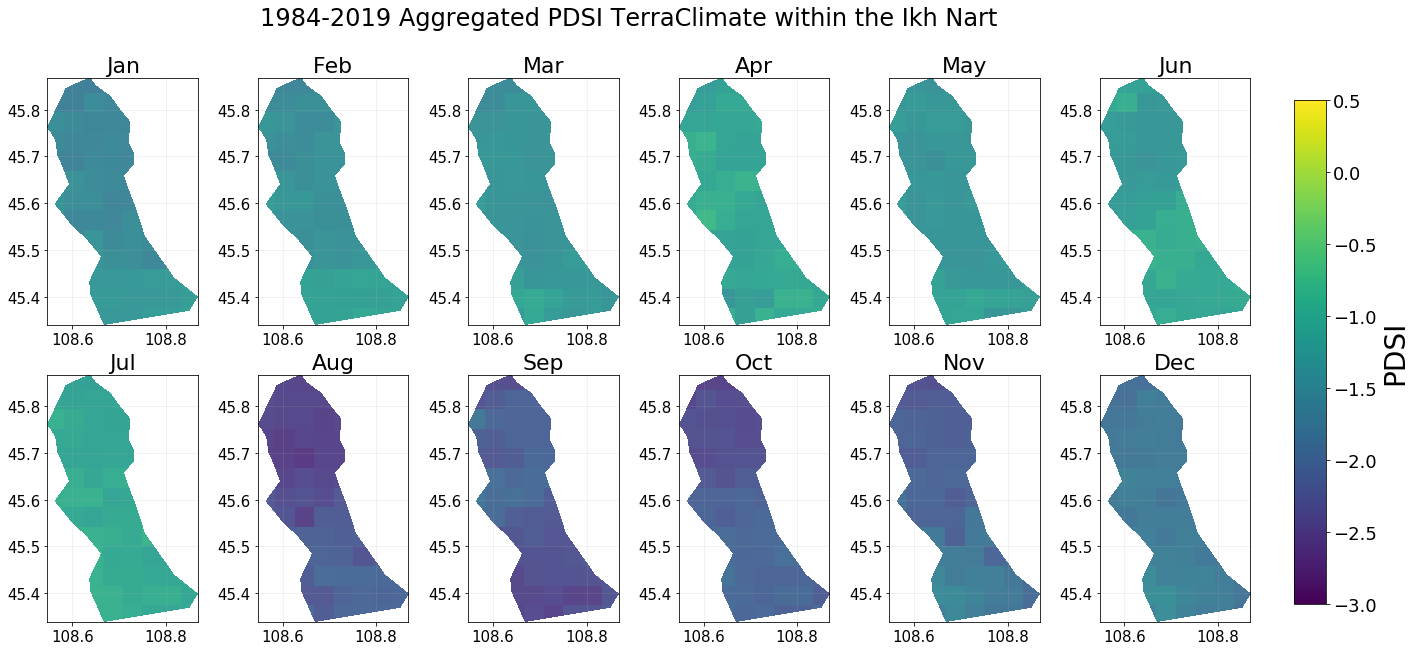

In [17]:
var = 3 
mn, mx = -3, 0.5 
r, c = 2,6
idxs = np.arange(r*c).reshape((r,c))
fig, ax = plt.subplots(r,c, figsize=(22,10))
for i in range(r):
    for j in range(c):
        im = rasterio.plot.show(m_imgs[idxs[i][j]].read(var)*0.01, ax=ax[i][j], \
                           vmin=mn, vmax=mx, alpha=0.9, extent=ext)
        ax[i][j].grid(alpha=0.2)
        ax[i][j].set_title(months[idxs[i][j]], fontsize=22)
        ax[i][j].tick_params(axis="both", labelsize=15) 
fig.suptitle('1984-2019 Aggregated %s TerraClimate within the Ikh Nart'%climate_labels[var],\
             fontsize=24)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=mn, vmax=mx)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=18) 
cb.set_label('%s'%climate_labels[var], fontsize=28)
fig.subplots_adjust(right=0.9)

fig.savefig('./out/ikhnart_%s.png'%climate_labels[var], dpi=300, bbox_inches='tight')

In [18]:
#now do growing season NDVI

In [19]:
f = sorted(glob('./data/geotiff/growing-season/*.tif'))
m_imgs = [rasterio.open(i) for i in f]

year = np.arange(1986,2020)
zeros = np.zeros((m_imgs[0].read(1).shape))

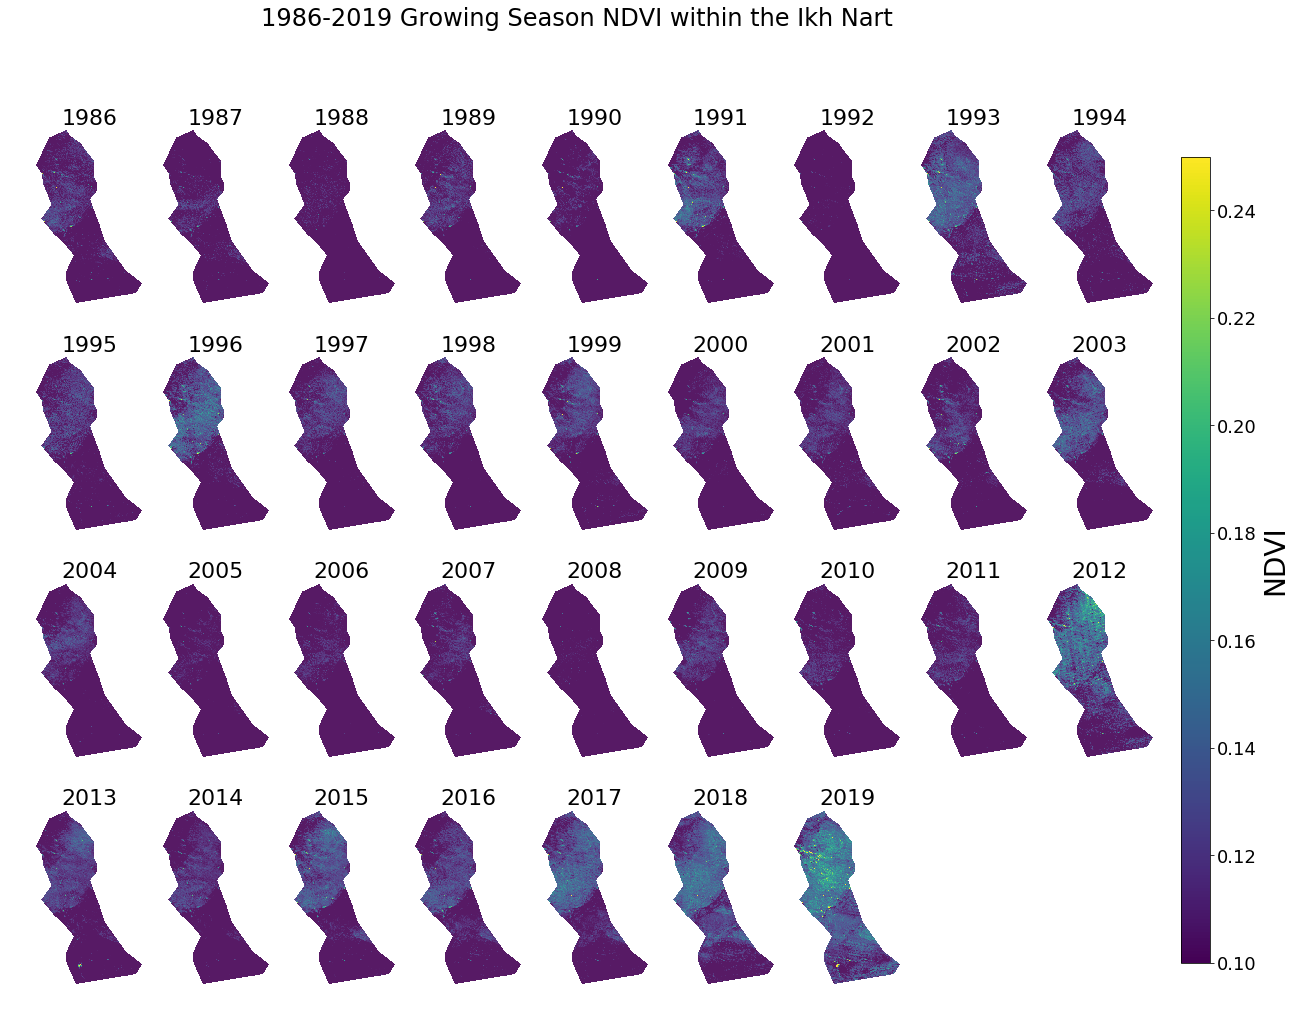

In [20]:
import matplotlib as mpl

r, c = 4,9
idxs = np.arange(r*c).reshape((r,c))
fig, ax = plt.subplots(r,c, figsize=(20,16))
mn, mx = 0.1, 0.25
for i in range(r):
    for j in range(c):
        #ax[i][j].imshow(hs, extent=ext, cmap='Greys')
        if idxs[i][j]>=len(year):
            ax[i][j].axis('off')
        else:
            im = rasterio.plot.show(m_imgs[idxs[i][j]], ax=ax[i][j], \
                               vmin=mn, vmax=mx, alpha=0.9, extent=ext)
            ax[i][j].grid(alpha=0.2)
            ax[i][j].set_title(year[idxs[i][j]], fontsize=22)
            ax[i][j].axis('off')
            #ax[i][j].tick_params(axis="both", labelbottom=False, labelleft=False) 
fig.suptitle('1986-2019 Growing Season NDVI within the Ikh Nart', fontsize=24)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=mn, vmax=mx)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=18) 
cb.set_label('NDVI', fontsize=28)
fig.subplots_adjust(right=0.9)

fig.savefig('./out/ikhnart_growing_NDVI.png', dpi=200, bbox_inches='tight')


In [42]:
import rasterio
f = sorted(glob('./data/projections/*tas*.tif'))
m_imgs = [rasterio.open(i) for i in f]
tasmin = np.array([np.mean(i.read(1))-273.15 for i in m_imgs])
tasmax = np.array([np.mean(i.read(2))-273.15 for i in m_imgs])
f = sorted(glob('./data/projections/*pr*.tif'))
m_imgs = [rasterio.open(i) for i in f]
pr = np.array([np.mean(i.read(1))*86400 for i in m_imgs])

year = np.arange(2019,2031)
zeros = np.zeros((m_imgs[0].read(1).shape))

f,ax = plt.subplots(3,1,figsize=(20,8))
ax[0].plot(year, tasmin)
ax[1].plot(year, tasmax)
ax[2].plot(year, pr)